In [1]:
import json
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
def process_string(string):
    string = re.sub('[^A-Za-z0-9\-\/ ]+', ' ', string).split()
    return [y.strip() for y in string]

In [3]:
with open('pos-data-v3.json','r') as fopen:
    dataset = json.load(fopen)

In [4]:
texts, labels = [], []
for i in dataset:
    try:
        texts.append(process_string(i[0])[0].lower())
        labels.append(i[-1])
    except Exception as e:
        print(e, i)

list index out of range ['%', '%', 'SYM']
list index out of range ['%', '%', 'SYM']
list index out of range ['*', '*', 'SYM']
list index out of range ['뭘봐', '뭘봐', 'PROPN']
list index out of range ['%', '%', 'SYM']
list index out of range ['ひ', 'ひ', 'PROPN']
list index out of range ['ヒ', 'ヒ', 'PROPN']
list index out of range ['形聲', '形聲', 'NOUN']
list index out of range ['°', '°', 'SYM']
list index out of range ['汉', '汉', 'PROPN']
list index out of range ['东', '东', 'PROPN']
list index out of range ['王', '王', 'PROPN']
list index out of range ['（', '（', 'PROPN']
list index out of range ['伊', '伊', 'PROPN']
list index out of range ['）', '）', 'PROPN']
list index out of range ['ȝ', 'ȝ', 'PROPN']
list index out of range ['%', '%', 'SYM']
list index out of range ['°', '°', 'SYM']
list index out of range ['%', '%', 'SYM']
list index out of range ["'", '_', 'PROPN']
list index out of range ['碁', '碁', 'NOUN']
list index out of range ['囲碁', '囲碁', 'NOUN']
list index out of range ['*', '*', 'SYM']
lis

In [5]:
word2idx = {'PAD': 0,'NUM':1,'UNK':2}
tag2idx = {'PAD': 0}
char2idx = {'PAD': 0}
word_idx = 3
tag_idx = 1
char_idx = 1

def parse_XY(texts, labels):
    global word2idx, tag2idx, char2idx, word_idx, tag_idx, char_idx
    X, Y = [], []
    for no, text in enumerate(texts):
        text = text.lower()
        tag = labels[no]
        for c in text:
            if c not in char2idx:
                char2idx[c] = char_idx
                char_idx += 1
        if tag not in tag2idx:
            tag2idx[tag] = tag_idx
            tag_idx += 1
        Y.append(tag2idx[tag])
        if text not in word2idx:
            word2idx[text] = word_idx
            word_idx += 1
        X.append(text)
    return X, np.array(Y)

In [6]:
X, Y = parse_XY(texts, labels)
idx2char = {idx: tag for tag, idx in char2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}
onehot = np.zeros((Y.shape[0],len(tag2idx)))
onehot[np.arange(Y.shape[0]),Y] = 1.0

In [7]:
def str_idx(corpus, dic, UNK=0):
    maxlen = max([len(i) for i in corpus])
    X = np.zeros((len(corpus),maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            try:
                X[i,-1 - no]=dic[k]
            except Exception as e:
                X[i,-1 - no]=UNK
    return X

In [8]:
X_seq = str_idx(X,char2idx)

In [9]:
import json
with open('char-bidirectional-pos.json','w') as fopen:
    fopen.write(json.dumps({'idx2tag':idx2tag, 'char2idx':char2idx,'tag2idx':tag2idx}))

In [10]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_seq, onehot, test_size=0.1)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
import keras
print(keras.__version__)

2.2.2


Using TensorFlow backend.


In [12]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional
from keras.backend.tensorflow_backend import set_session
set_session(tf.InteractiveSession())

In [13]:
input_word = Input(shape=(None,))
model = Embedding(input_dim=len(char2idx) + 1, output_dim=128, mask_zero=True)(input_word)
model = Bidirectional(LSTM(units=128, return_sequences=False, recurrent_dropout=0.1))(model)
out = Dense(len(tag2idx),activation='softmax')(model)

In [14]:
model = Model(input_word, out)

In [15]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         5120      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
Total params: 272,400
Trainable params: 272,400
Non-trainable params: 0
_________________________________________________________________


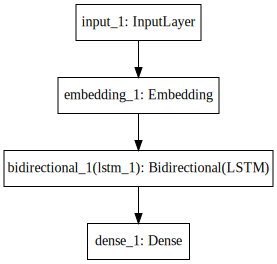

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [18]:
history = model.fit(train_X, train_Y, batch_size=32, epochs=2,
                    validation_split=0.1, verbose=1)

Train on 83767 samples, validate on 9308 samples
Epoch 1/2
83767/83767 [==============================] - 147s 2ms/step - loss: 0.9461 - acc: 0.6823 - val_loss: 0.6229 - val_acc: 0.7899
Epoch 2/2
83767/83767 [==============================] - 146s 2ms/step - loss: 0.5629 - acc: 0.8105 - val_loss: 0.5081 - val_acc: 0.8290


In [19]:
predicted = model.predict(test_X)
labels = [i[0] for i in sorted(tag2idx.items(), key=lambda t: t[1])]

In [20]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_Y,1), np.argmax(predicted,1), target_names=labels[1:]))

             precision    recall  f1-score   support

       NOUN       0.74      0.82      0.78      2709
        ADP       0.95      0.96      0.95      1202
        NUM       0.92      0.92      0.92       448
       VERB       0.92      0.90      0.91      1183
      PROPN       0.76      0.73      0.74      2233
      CCONJ       0.98      0.94      0.96       375
        ADJ       0.71      0.47      0.56       453
       PRON       0.93      0.94      0.94       528
        ADV       0.84      0.75      0.79       470
        AUX       0.99      1.00      1.00       124
        DET       0.90      0.92      0.91       397
      SCONJ       0.64      0.76      0.69       143
       PART       0.77      0.89      0.82        55
        SYM       1.00      0.85      0.92        20
          X       0.00      0.00      0.00         2

avg / total       0.83      0.83      0.82     10342



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
model.save_weights('char-bidirectional-pos.h5')